In [1]:
# import general classes for data processing
import ruptures as rpt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

# import custom classes 
from model import Signal, GestureRecognitionModel
from model import GestureRecognitionDataset

# import SVM classes
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.preprocessing import StandardScaler


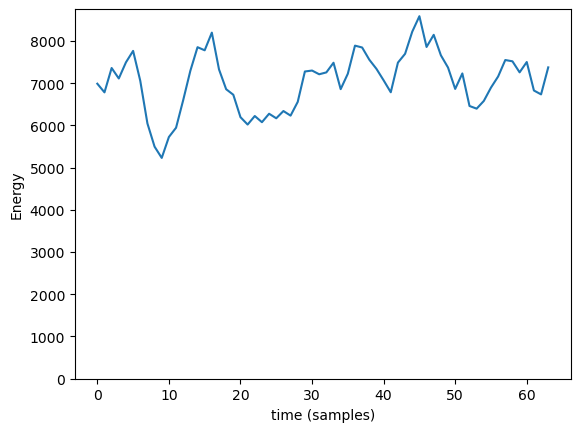

In [5]:

signal = Signal(path_to_file=path_to_file)
#  add zeros to signal
num_zeros = 10 
zeros_to_add = np.zeros((num_zeros, signal.signal.shape[1]))  # Assuming signal.signal is a 2D array
signal.signal = np.concatenate((zeros_to_add, signal.signal), axis=0)

signal.remove_transition(algorithm="Binseg")

# Now 'signal' contains the signal after the change point
signal.display(attr="energy", w=5)

10


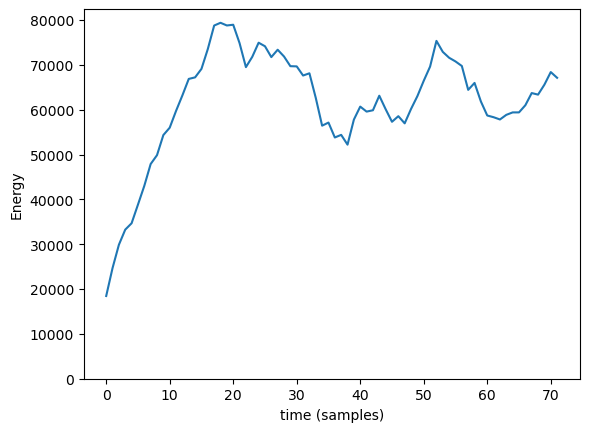

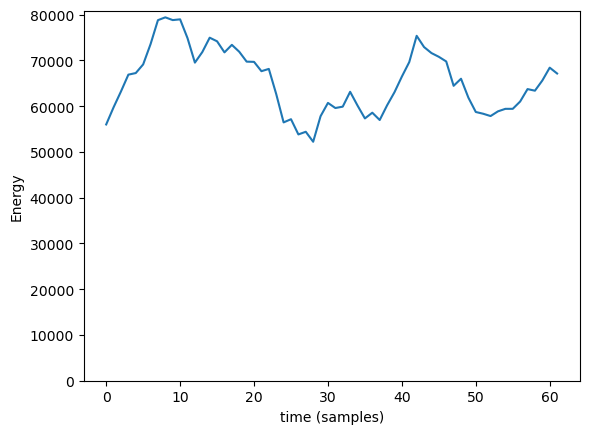

In [421]:
signalpath_notransition = "data\Mario2\ClosedHand_3.npy"
min_s = 10
transition = "on"
add_transition = "off"

if transition == "on":
    path_to_file = "data\dataJoel\Joel1\ThumbAbduction_3.npy"
else:
    path_to_file = signalpath_notransition

signal = Signal(path_to_file=path_to_file)

if add_transition == "on":
    num_zeros = 25
    zeros_to_add = np.zeros((num_zeros, signal.signal.shape[1]))  # assuming signal.signal is a 2D array
    signal.signal = np.concatenate((zeros_to_add, signal.signal), axis=0)
else:
    signal.signal = signal.signal 

signal.display(attr="energy", w=5)

step = 10

# initialize change point detection with Pelt
s = signal.get_features(list_features=["mav"]).sum(axis=1)

algo = rpt.Pelt(model="l2", min_size=min_s).fit(s)
result = algo.predict(pen=20)[0]
print(result)
limit = (0.25*signal.signal.shape[0])/step

if result > limit:
    result = round((0*signal.signal.shape[0])/step)

trans_idx = result*step

# remove phase of transition
signal.signal = signal.signal[trans_idx:, :]
signal.n_samples = signal.signal.shape[0]

signal.display(attr="energy", w=5)

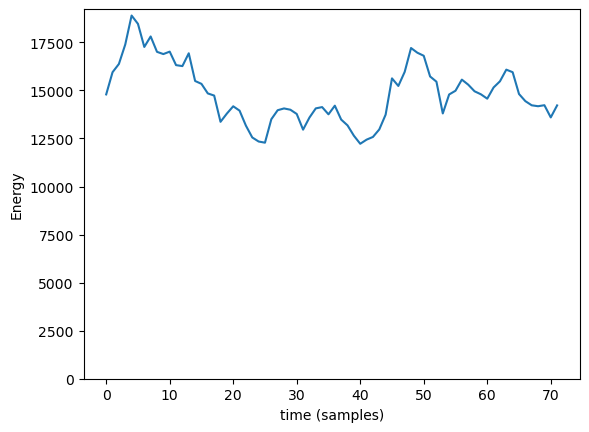

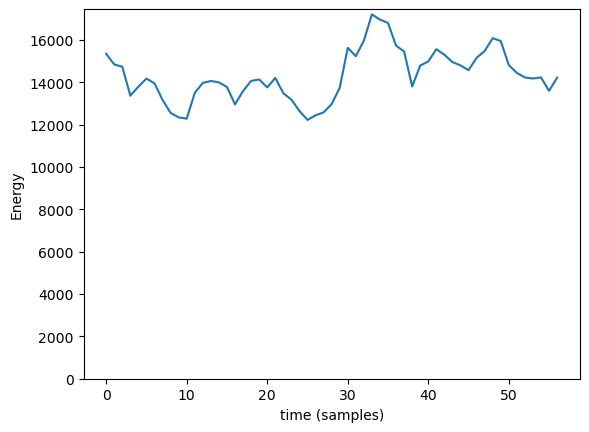

In [459]:
signalpath_notransition = "data\Mario2\ClosedHand_3.npy"
min_s = 10

transition = "off"
add_transition = "off"

if transition == "on":
    path_to_file = "data\dataJoel\Joel1\ThumbAbduction_3.npy"
else:
    path_to_file = signalpath_notransition

signal = Signal(path_to_file=path_to_file)

if add_transition == "on":
    num_zeros = 25
    zeros_to_add = np.zeros((num_zeros, signal.signal.shape[1]))  # assuming signal.signal is a 2D array
    signal.signal = np.concatenate((zeros_to_add, signal.signal), axis=0)
else:
    signal.signal = signal.signal 
    
signal.display(attr="energy", w=5)
step = 10

limit = (0.25*signal.signal.shape[0])/step 
result = signal.signal.shape[0]/step

while result > limit:
    min_s -= 1 
    if min_s < 1: 
        break

    # initialize change point detection with Pelt
    s = signal.get_features(list_features=["mav"]).sum(axis=1)

    algo = rpt.Pelt(model="l2", min_size=min_s).fit(s)
    result = algo.predict(pen=20)[0]

if result < limit:

    trans_idx = result*step

    # remove phase of transition
    signal.signal = signal.signal[trans_idx:, :]
    signal.n_samples = signal.signal.shape[0]

    signal.display(attr="energy", w=5)

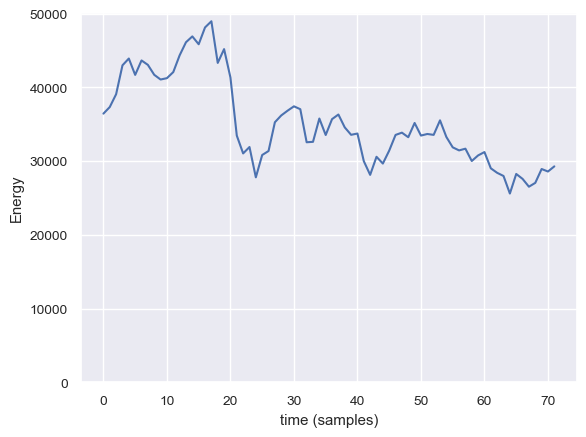

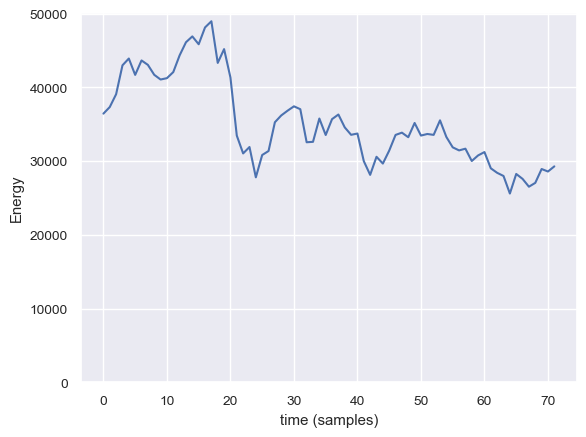

In [33]:
path_to_file = "data\Mario2\ThumbAbduction_1.npy"
step = 10

signal = Signal(path_to_file=path_to_file)
signal.display(attr="energy", w=5)
signal.remove_transition(algorithm="mean")
signal.display(attr="energy", w=5)

In [3]:
# testing initial model on this new data

# initialize dataset 
path_to_dataset = "data"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,             ## what is different in v1? Got no gestures in v2
                                    version="v1", save_df=False, 
                                    remove_transition=True)

df = gr.get_features()
subject = 'Lluis'
Take_to_test = '1'

df = df[(df['subject'] == subject)]


  0%|          | 0/2102 [00:00<?, ?it/s]

100%|██████████| 2102/2102 [02:49<00:00, 12.39it/s]


In [12]:
# instantiate the model 
model_type = "xgboost"
kernel = "poly"
model = GestureRecognitionModel(model_name=model_type,kernel = kernel)


In [13]:
#selecting X (features) and Y (gestures) 

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

# here I tested if the length of the features had any influence on the accuracy, this was not the case, so this can be skipped. 
# Find the length of the shortest column
#min_length = min(len(df[column]) for column in columns_x)

# Truncate each column to the length of the shortest column
#columns_x = [column[:min_length] for column in columns_x]

df_train = df[(df['take'] != Take_to_test)]
df_test = df[(df['take'] == Take_to_test)]

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

if kernel == 'linear' or kernel == 'sigmoid':
       scaler = StandardScaler() 
       X_train = scaler.fit_transform(X_train)
       X_test = scaler.transform(X_test)
else: 
       X_train = X_train
       X_test = X_test

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.train(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 82.67%


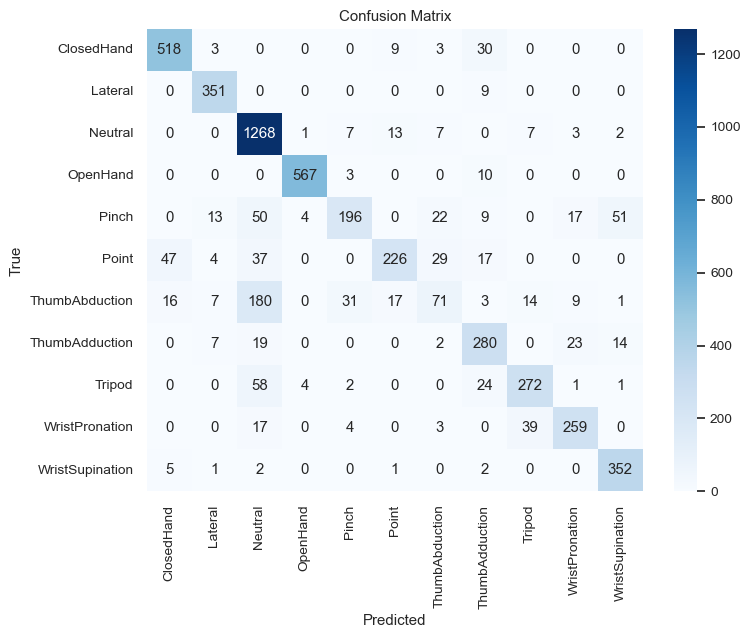

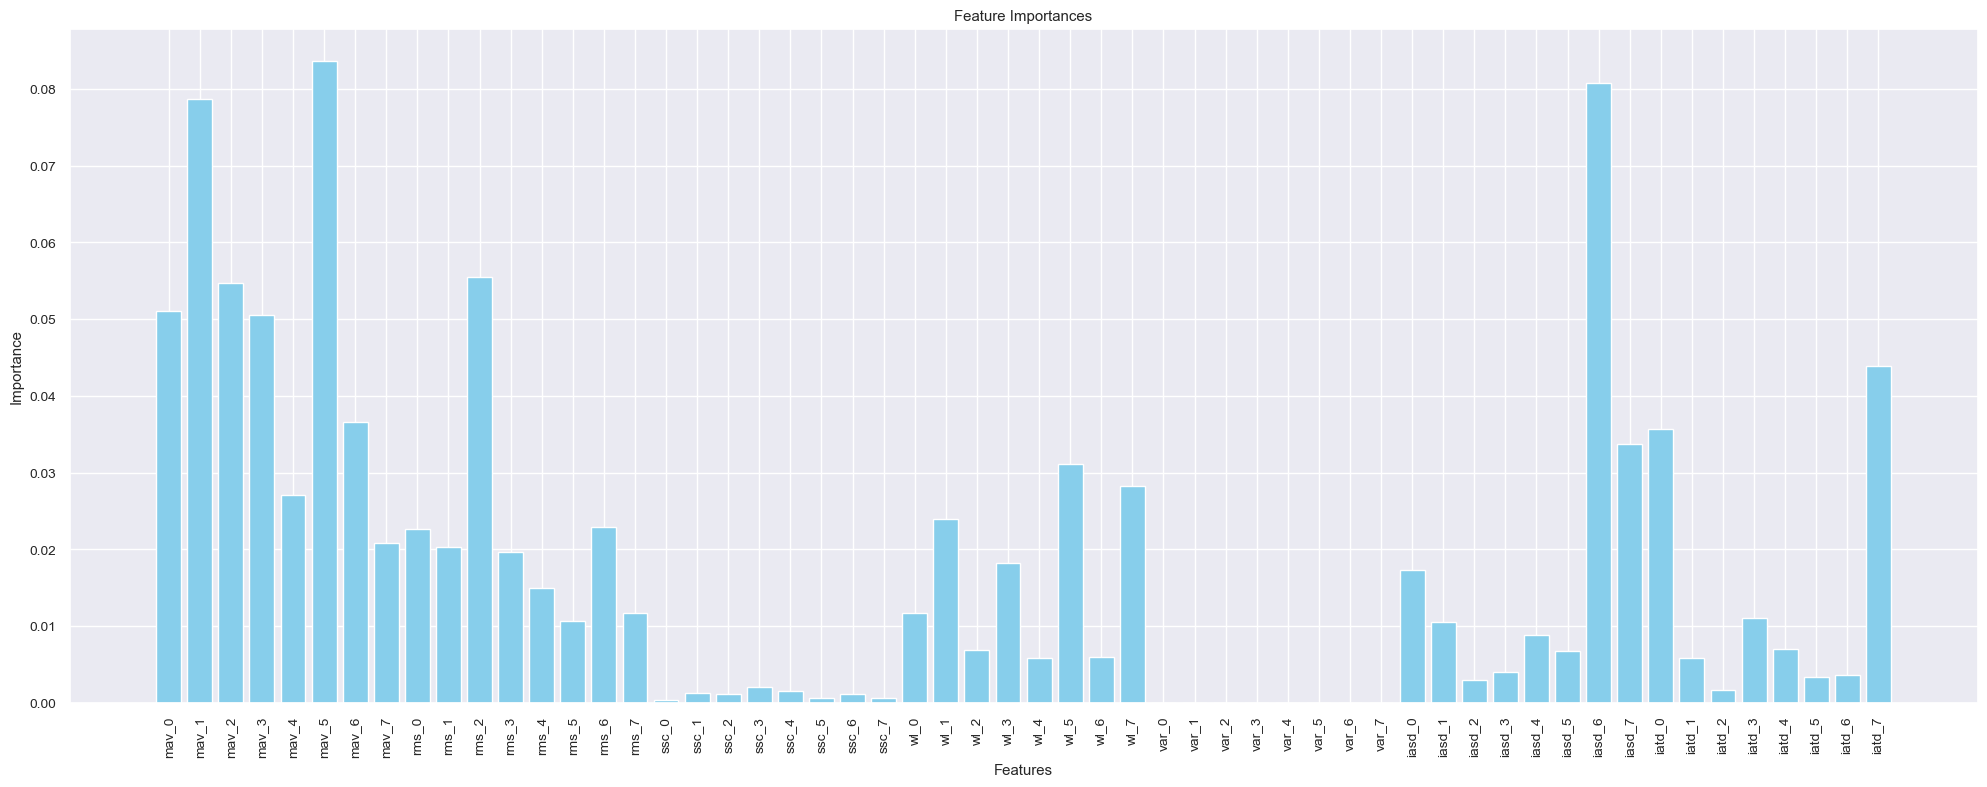

In [4]:
# plotting confusion matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Get class labels
class_labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)  # Adjust to fit labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

feature_importances = model.model.feature_importances_
features = ['mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']


plt.figure(figsize=(20, 8))
plt.bar(features, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [26]:
svm = SVC(kernel=Kernel)  
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 81.74%


In [40]:
# treat class imbalance

#selecting X (features) and Y (gestures) 

selected_columns = [ 'mav_0', 'mav_1', 'mav_2', 'mav_3', 'mav_4', 'mav_5', 'mav_6', 'mav_7',
       'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
       'ssc_0', 'ssc_1', 'ssc_2', 'ssc_3', 'ssc_4', 'ssc_5', 'ssc_6', 'ssc_7',
       'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'iasd_0',
       'iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
       'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
       'iatd_7']

# here I tested if the length of the features had any influence on the accuracy, this was not the case, so this can be skipped. 
# Find the length of the shortest column
#min_length = min(len(df[column]) for column in columns_x)

# Truncate each column to the length of the shortest column
#columns_x = [column[:min_length] for column in columns_x]

df_train = df[(df['take'] != Take_to_test)]
df_test = df[(df['take'] == Take_to_test)]

# Downsampling the "neutral" class in the training set
neutral_df = df_train[df_train['gesture'] == 'Neutral']
non_neutral_df = df_train[df_train['gesture'] != 'Neutral']

# Randomly sample 1/3 of the "neutral" class instances
neutral_downsampled = neutral_df.sample(frac=1/3)

# Concatenate the downsampled neutral class with the rest of the training data
df_train = pd.concat([non_neutral_df, neutral_downsampled])

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.train(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))


The accuracy of the model is 82.21%
